# Colab Setup  
> Make sure you configure notebook with GPU: Click Edit->notebook settings->hardware accelerator->GPU

> Uncomment the following cell after opening in Google colab. (Do not uncomment it in local setup.)  

<a target="_blank" href="https://colab.research.google.com/github/SEED-VT/FedDebug/blob/main/fault-localization/Reproduce_Figure4-Figure7.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



In [1]:
# !pip install pytorch-lightning
# !pip install diskcache
# !pip install dotmap
# !pip install torch torchvision torchaudio
# !pip install matplotlib
# !git clone https://github.com/SEED-VT/FedDebug.git
# # appending the path
# import sys
# sys.path.append("FedDebug/fault-localization/")

# Descripiton

- The code is simulating the presence of a faulty client in a federated learning setting by introducing noise to the model updates from a faulty client. The `noise_rate` variable is used to control the amount of noise added.

- For each noise level, the code performs FL training, aggregation to update the global model, and testing of the global model's accuracy. 

- The code also runs `FedDebug's fault localization algorithm` to identify potentially faulty clients and evaluate the accuracy of the fault localization. 

- The results of the simulation are stored in a list, and the `global model accuracy` and `fault localization accuracy` are plotted against the `noise rate`.


In [2]:
import logging
import matplotlib.pyplot as plt
import time
from dotmap import DotMap
from pytorch_lightning import seed_everything
from torch.nn.init import kaiming_uniform_ 
from utils.faulty_client_localization.FaultyClientLocalization import FaultyClientLocalization
from utils.faulty_client_localization.InferenceGuidedInputs import InferenceGuidedInputs
from utils.FLSimulation import trainFLMain
from utils.fl_datasets import initializeTrainAndValidationDataset
from utils.util import aggToUpdateGlobalModel
from utils.util import testAccModel



logging.basicConfig(filename='example.log', level=logging.ERROR)
logger = logging.getLogger("pytorch_lightning")
seed_everything(786)



def evaluateFaultLocalization(predicted_faulty_clients_on_each_input, true_faulty_clients):
    true_faulty_clients = set(true_faulty_clients)
    detection_acc = 0
    for pred_faulty_clients in predicted_faulty_clients_on_each_input:
        print(f"+++ Faulty Clients {pred_faulty_clients}")
        correct_localize_faults = len(
            true_faulty_clients.intersection(pred_faulty_clients))
        acc = (correct_localize_faults/len(true_faulty_clients))*100
        detection_acc += acc
    fault_localization_acc = detection_acc / \
        len(predicted_faulty_clients_on_each_input)
    return fault_localization_acc


def runFaultyClientLocalization(client2models, exp2info, num_bugs, random_generator=kaiming_uniform_, apply_transform=True, k_gen_inputs=10, na_threshold=0.003, use_gpu=True):
    print(">  Running FaultyClientLocalization ..")
    input_shape = list(exp2info['data_config']['single_input_shape'])
    generate_inputs = InferenceGuidedInputs(client2models, input_shape, randomGenerator=random_generator, apply_transform=apply_transform,
                                            dname=exp2info['data_config']['name'], min_nclients_same_pred=5, k_gen_inputs=k_gen_inputs)
    selected_inputs, input_gen_time = generate_inputs.getInputs()

    start = time.time()
    faultyclientlocalization = FaultyClientLocalization(
        client2models, selected_inputs, use_gpu=use_gpu)

    potential_benign_clients_for_each_input = faultyclientlocalization.runFaultLocalization(
        na_threshold, num_bugs=num_bugs)
    fault_localization_time = time.time()-start
    return potential_benign_clients_for_each_input, input_gen_time, fault_localization_time





# ====== Simulation ===== 

args = DotMap()
args.lr = 0.001
args.weight_decay = 0.0001
args.batch_size = 512

nosie2results = []
different_noise_levels = [0.1, 0.3, 0.5, 0.7, 0.9, 1]
args.model = "resnet34" # [resnet18, resnet34, resnet50, densenet121, vgg16]
args.epochs = 5  # range 10-25
args.dataset = "cifar10" # ['cifar10', 'femnist']
args.clients = 10 # keep under 30 clients and use Resnet18, Resnet34, or Densenet to evaluate on Colab 
args.faulty_clients_ids = "0" # can be multiple clients separated by comma e.g. "0,1,2"  but keep under args.clients clients and at max less than 7 
args.sampling = "iid" # [iid, "niid"] 

_,test_data, _ =  initializeTrainAndValidationDataset(args.dataset, ".storage/datasets/")

for noise_rate in different_noise_levels:
    args.noise_rate = noise_rate  # noise rate 0 to 1 
    # FL training
    c2ms, exp2info = trainFLMain(args)
    client2models = {k: v.model.eval() for k, v in c2ms.items()}

    gm =  aggToUpdateGlobalModel(clients_models=client2models)
    test_acc = testAccModel(gm, test_data)

    # Fault localazation
    potential_faulty_clients, _, _ = runFaultyClientLocalization(
        client2models=client2models, exp2info=exp2info, num_bugs=len(exp2info['faulty_clients_ids']))
    fault_acc = evaluateFaultLocalization(
        potential_faulty_clients, exp2info['faulty_clients_ids'])
    print(f"Fault Localization Acc: {fault_acc}")

    print(f"Gloabl Model Test Acc: {test_acc}, Noise Rate: {noise_rate}, Fault Acc: {fault_acc}")
    nosie2results.append((noise_rate, test_acc, fault_acc))



/home/gulzar/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 786
Global seed set to 786


Files already downloaded and verified
Files already downloaded and verified


  ***Simulating FL setup iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001 ***
Files already downloaded and verified
Files already downloaded and verified
Spliting Datasets 50000 into parts:[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]
input shape, torch.Size([1, 3, 32, 32])


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/gulzar/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 106MB/s] 


Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/faulty_client_0_noise_rate_0.1_classes.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Train mod batch = 392, and drop_last = False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.85it/s, loss=0.932, train_acc=0.660, train_loss=0.886, val_acc=0.564, val_loss=1.650]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.84it/s, loss=0.932, train_acc=0.660, train_loss=0.886, val_acc=0.564, val_loss=1.650]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_1.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  4.44it/s, loss=0.752, train_acc=0.762, train_loss=0.676, val_acc=0.640, val_loss=1.350]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  4.43it/s, loss=0.752, train_acc=0.762, train_loss=0.676, val_acc=0.640, val_loss=1.350]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_2.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.86it/s, loss=0.755, train_acc=0.769, train_loss=0.689, val_acc=0.637, val_loss=1.270]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.86it/s, loss=0.755, train_acc=0.769, train_loss=0.689, val_acc=0.637, val_loss=1.270]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_3.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s, loss=0.746, train_acc=0.753, train_loss=0.717, val_acc=0.594, val_loss=1.810]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s, loss=0.746, train_acc=0.753, train_loss=0.717, val_acc=0.594, val_loss=1.810]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_4.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  4.29it/s, loss=0.745, train_acc=0.754, train_loss=0.713, val_acc=0.647, val_loss=1.280]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  4.28it/s, loss=0.745, train_acc=0.754, train_loss=0.713, val_acc=0.647, val_loss=1.280]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_5.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Train mod batch = 392, and drop_last = False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s, loss=0.745, train_acc=0.808, train_loss=0.662, val_acc=0.647, val_loss=1.290]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s, loss=0.745, train_acc=0.808, train_loss=0.662, val_acc=0.647, val_loss=1.290]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_6.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s, loss=0.725, train_acc=0.787, train_loss=0.647, val_acc=0.642, val_loss=1.350]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s, loss=0.725, train_acc=0.787, train_loss=0.647, val_acc=0.642, val_loss=1.350]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_7.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  4.25it/s, loss=0.779, train_acc=0.771, train_loss=0.678, val_acc=0.622, val_loss=1.320]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  4.25it/s, loss=0.779, train_acc=0.771, train_loss=0.678, val_acc=0.622, val_loss=1.320]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_8.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s, loss=0.755, train_acc=0.740, train_loss=0.761, val_acc=0.635, val_loss=1.360]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s, loss=0.755, train_acc=0.740, train_loss=0.761, val_acc=0.635, val_loss=1.360]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_9.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Train mod batch = 392, and drop_last = False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s, loss=0.75, train_acc=0.757, train_loss=0.725, val_acc=0.633, val_loss=1.310] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  2.69it/s, loss=0.75, train_acc=0.757, train_loss=0.725, val_acc=0.633, val_loss=1.310]
Total clients: 10
++Training is done: iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001
>  Running FaultyClientLocalization ..
Same prediction threshold 5
+++ Faulty Clients {7}
+++ Faulty Clients {7}
+++ Faulty Clients {7}
+++ Faulty Clients {7}
+++ Faulty Clients {7}
+++ Faulty Clients {7}
+++ Faulty Clients {7}
+++ Faulty Clients {7}
+++ Faulty Clients {7}
+++ Faulty Clients {7}
Fault Localization Acc: 0.0
Gloabl Model Test Acc: 66.3, Noise Rate: 0.1, Fault Acc: 0.0


  ***Simulating FL setup iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001 ***
Files already downloaded and verified
Files already downloaded and verified
Spliting Datasets 50000 into parts:[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]
input shape, torch.Size([1, 3, 32, 32])
Training : .storage/checkpoints/iid_resnet34_cifar10_clie

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  4.14it/s, loss=1.26, train_acc=0.489, train_loss=1.150, val_acc=0.441, val_loss=1.860]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  4.13it/s, loss=1.26, train_acc=0.489, train_loss=1.150, val_acc=0.441, val_loss=1.860]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_1.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.51it/s, loss=0.762, train_acc=0.772, train_loss=0.687, val_acc=0.627, val_loss=1.510]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.51it/s, loss=0.762, train_acc=0.772, train_loss=0.687, val_acc=0.627, val_loss=1.510]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_2.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s, loss=0.769, train_acc=0.763, train_loss=0.711, val_acc=0.608, val_loss=1.850]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s, loss=0.769, train_acc=0.763, train_loss=0.711, val_acc=0.608, val_loss=1.850]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_3.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s, loss=0.734, train_acc=0.769, train_loss=0.668, val_acc=0.651, val_loss=1.150]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s, loss=0.734, train_acc=0.769, train_loss=0.668, val_acc=0.651, val_loss=1.150]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_4.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.99it/s, loss=0.758, train_acc=0.729, train_loss=0.773, val_acc=0.659, val_loss=1.140]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.98it/s, loss=0.758, train_acc=0.729, train_loss=0.773, val_acc=0.659, val_loss=1.140]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_5.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s, loss=0.787, train_acc=0.728, train_loss=0.761, val_acc=0.602, val_loss=1.610]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s, loss=0.787, train_acc=0.728, train_loss=0.761, val_acc=0.602, val_loss=1.610]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_6.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s, loss=0.741, train_acc=0.768, train_loss=0.680, val_acc=0.627, val_loss=1.670]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s, loss=0.741, train_acc=0.768, train_loss=0.680, val_acc=0.627, val_loss=1.670]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_7.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Train mod batch = 392, and drop_last = False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s, loss=0.733, train_acc=0.775, train_loss=0.708, val_acc=0.650, val_loss=1.140]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s, loss=0.733, train_acc=0.775, train_loss=0.708, val_acc=0.650, val_loss=1.140]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_8.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s, loss=0.765, train_acc=0.777, train_loss=0.627, val_acc=0.624, val_loss=1.390]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s, loss=0.765, train_acc=0.777, train_loss=0.627, val_acc=0.624, val_loss=1.390]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_9.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s, loss=0.75, train_acc=0.734, train_loss=0.788, val_acc=0.653, val_loss=1.140] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s, loss=0.75, train_acc=0.734, train_loss=0.788, val_acc=0.653, val_loss=1.140]
Total clients: 10
++Training is done: iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001
>  Running FaultyClientLocalization ..
Same prediction threshold 5
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
Fault Localization Acc: 100.0
Gloabl Model Test Acc: 69.73, Noise Rate: 0.3, Fault Acc: 100.0


  ***Simulating FL setup iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001 ***
Files already downloaded and verified
Files already downloaded and verified
Spliting Datasets 50000 into parts:[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]
input shape, torch.Size([1, 3, 32, 32])
Training : .storage/checkpoints/iid_resnet34_cifar10

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s, loss=1.61, train_acc=0.341, train_loss=1.560, val_acc=0.285, val_loss=1.980]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s, loss=1.61, train_acc=0.341, train_loss=1.560, val_acc=0.285, val_loss=1.980]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_1.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s, loss=0.737, train_acc=0.742, train_loss=0.705, val_acc=0.619, val_loss=1.530]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s, loss=0.737, train_acc=0.742, train_loss=0.705, val_acc=0.619, val_loss=1.530]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_2.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s, loss=0.784, train_acc=0.738, train_loss=0.702, val_acc=0.644, val_loss=1.290]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.68it/s, loss=0.784, train_acc=0.738, train_loss=0.702, val_acc=0.644, val_loss=1.290]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_3.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.65it/s, loss=0.799, train_acc=0.765, train_loss=0.697, val_acc=0.623, val_loss=1.550]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.65it/s, loss=0.799, train_acc=0.765, train_loss=0.697, val_acc=0.623, val_loss=1.550]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_4.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s, loss=0.758, train_acc=0.755, train_loss=0.733, val_acc=0.645, val_loss=1.220]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s, loss=0.758, train_acc=0.755, train_loss=0.733, val_acc=0.645, val_loss=1.220]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_5.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s, loss=0.741, train_acc=0.744, train_loss=0.743, val_acc=0.640, val_loss=1.360]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s, loss=0.741, train_acc=0.744, train_loss=0.743, val_acc=0.640, val_loss=1.360]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_6.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.69it/s, loss=0.697, train_acc=0.752, train_loss=0.678, val_acc=0.659, val_loss=1.300]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.69it/s, loss=0.697, train_acc=0.752, train_loss=0.678, val_acc=0.659, val_loss=1.300]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_7.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s, loss=0.721, train_acc=0.780, train_loss=0.637, val_acc=0.619, val_loss=2.090]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s, loss=0.721, train_acc=0.780, train_loss=0.637, val_acc=0.619, val_loss=2.090]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_8.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s, loss=0.769, train_acc=0.723, train_loss=0.781, val_acc=0.634, val_loss=1.360]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s, loss=0.769, train_acc=0.723, train_loss=0.781, val_acc=0.634, val_loss=1.360]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_9.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.59it/s, loss=0.775, train_acc=0.743, train_loss=0.764, val_acc=0.640, val_loss=1.210]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.58it/s, loss=0.775, train_acc=0.743, train_loss=0.764, val_acc=0.640, val_loss=1.210]
Total clients: 10
++Training is done: iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001
>  Running FaultyClientLocalization ..
Same prediction threshold 5
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
Fault Localization Acc: 100.0
Gloabl Model Test Acc: 63.76, Noise Rate: 0.5, Fault Acc: 100.0


  ***Simulating FL setup iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001 ***
Files already downloaded and verified
Files already downloaded and verified
Spliting Datasets 50000 into parts:[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]
input shape, torch.Size([1, 3, 32, 32])
Training : .storage/checkpoints/iid_resnet34_cifar1

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s, loss=1.91, train_acc=0.237, train_loss=1.820, val_acc=0.189, val_loss=2.180]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s, loss=1.91, train_acc=0.237, train_loss=1.820, val_acc=0.189, val_loss=2.180]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_1.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s, loss=0.729, train_acc=0.761, train_loss=0.700, val_acc=0.642, val_loss=1.640]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s, loss=0.729, train_acc=0.761, train_loss=0.700, val_acc=0.642, val_loss=1.640]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_2.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s, loss=0.739, train_acc=0.775, train_loss=0.667, val_acc=0.647, val_loss=1.280]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s, loss=0.739, train_acc=0.775, train_loss=0.667, val_acc=0.647, val_loss=1.280]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_3.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s, loss=0.71, train_acc=0.752, train_loss=0.710, val_acc=0.638, val_loss=1.490] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s, loss=0.71, train_acc=0.752, train_loss=0.710, val_acc=0.638, val_loss=1.490]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_4.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.59it/s, loss=0.773, train_acc=0.702, train_loss=0.782, val_acc=0.612, val_loss=1.540]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.58it/s, loss=0.773, train_acc=0.702, train_loss=0.782, val_acc=0.612, val_loss=1.540]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_5.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s, loss=0.763, train_acc=0.749, train_loss=0.698, val_acc=0.605, val_loss=2.200]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s, loss=0.763, train_acc=0.749, train_loss=0.698, val_acc=0.605, val_loss=2.200]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_6.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s, loss=0.733, train_acc=0.772, train_loss=0.662, val_acc=0.632, val_loss=1.500]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s, loss=0.733, train_acc=0.772, train_loss=0.662, val_acc=0.632, val_loss=1.500]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_7.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s, loss=0.736, train_acc=0.753, train_loss=0.702, val_acc=0.627, val_loss=1.560]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s, loss=0.736, train_acc=0.753, train_loss=0.702, val_acc=0.627, val_loss=1.560]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_8.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s, loss=0.746, train_acc=0.766, train_loss=0.656, val_acc=0.642, val_loss=1.330]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s, loss=0.746, train_acc=0.766, train_loss=0.656, val_acc=0.642, val_loss=1.330]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_9.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.63it/s, loss=0.78, train_acc=0.750, train_loss=0.792, val_acc=0.623, val_loss=1.520] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.62it/s, loss=0.78, train_acc=0.750, train_loss=0.792, val_acc=0.623, val_loss=1.520]
Total clients: 10
++Training is done: iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001
>  Running FaultyClientLocalization ..
Same prediction threshold 5
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
Fault Localization Acc: 100.0
Gloabl Model Test Acc: 64.41, Noise Rate: 0.7, Fault Acc: 100.0


  ***Simulating FL setup iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001 ***
Files already downloaded and verified
Files already downloaded and verified
Spliting Datasets 50000 into parts:[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]
input shape, torch.Size([1, 3, 32, 32])
Training : .storage/checkpoints/iid_resnet34_cifar10

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s, loss=2.16, train_acc=0.106, train_loss=2.120, val_acc=0.114, val_loss=2.500]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s, loss=2.16, train_acc=0.106, train_loss=2.120, val_acc=0.114, val_loss=2.500]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_1.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.58it/s, loss=0.733, train_acc=0.781, train_loss=0.680, val_acc=0.653, val_loss=1.190]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s, loss=0.733, train_acc=0.781, train_loss=0.680, val_acc=0.653, val_loss=1.190]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_2.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.63it/s, loss=0.751, train_acc=0.775, train_loss=0.709, val_acc=0.651, val_loss=1.190]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.62it/s, loss=0.751, train_acc=0.775, train_loss=0.709, val_acc=0.651, val_loss=1.190]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_3.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.55it/s, loss=0.771, train_acc=0.738, train_loss=0.798, val_acc=0.624, val_loss=1.360]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.54it/s, loss=0.771, train_acc=0.738, train_loss=0.798, val_acc=0.624, val_loss=1.360]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_4.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s, loss=0.785, train_acc=0.768, train_loss=0.708, val_acc=0.627, val_loss=1.430]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.74it/s, loss=0.785, train_acc=0.768, train_loss=0.708, val_acc=0.627, val_loss=1.430]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_5.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s, loss=0.777, train_acc=0.762, train_loss=0.675, val_acc=0.640, val_loss=1.360]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s, loss=0.777, train_acc=0.762, train_loss=0.675, val_acc=0.640, val_loss=1.360]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_6.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s, loss=0.752, train_acc=0.740, train_loss=0.723, val_acc=0.662, val_loss=1.020]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  2.70it/s, loss=0.752, train_acc=0.740, train_loss=0.723, val_acc=0.662, val_loss=1.020]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_7.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s, loss=0.733, train_acc=0.755, train_loss=0.731, val_acc=0.650, val_loss=1.170]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s, loss=0.733, train_acc=0.755, train_loss=0.731, val_acc=0.650, val_loss=1.170]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_8.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s, loss=0.747, train_acc=0.795, train_loss=0.588, val_acc=0.663, val_loss=1.120]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s, loss=0.747, train_acc=0.795, train_loss=0.588, val_acc=0.663, val_loss=1.120]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_9.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.60it/s, loss=0.763, train_acc=0.736, train_loss=0.742, val_acc=0.644, val_loss=1.340]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.60it/s, loss=0.763, train_acc=0.736, train_loss=0.742, val_acc=0.644, val_loss=1.340]
Total clients: 10
++Training is done: iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001
>  Running FaultyClientLocalization ..
Same prediction threshold 5
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
Fault Localization Acc: 100.0
Gloabl Model Test Acc: 47.81, Noise Rate: 0.9, Fault Acc: 100.0


  ***Simulating FL setup iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001 ***
Files already downloaded and verified
Files already downloaded and verified
Spliting Datasets 50000 into parts:[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]
input shape, torch.Size([1, 3, 32, 32])
Training : .storage/checkpoints/iid_resnet34_cifar1

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Train mod batch = 392, and drop_last = False


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s, loss=2.3, train_acc=0.130, train_loss=2.300, val_acc=0.0961, val_loss=2.380] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s, loss=2.3, train_acc=0.130, train_loss=2.300, val_acc=0.0961, val_loss=2.380]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_1.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s, loss=0.775, train_acc=0.768, train_loss=0.657, val_acc=0.633, val_loss=1.210]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s, loss=0.775, train_acc=0.768, train_loss=0.657, val_acc=0.633, val_loss=1.210]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_2.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s, loss=0.734, train_acc=0.761, train_loss=0.646, val_acc=0.660, val_loss=1.190]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s, loss=0.734, train_acc=0.761, train_loss=0.646, val_acc=0.660, val_loss=1.190]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_3.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  2.87it/s, loss=0.739, train_acc=0.775, train_loss=0.733, val_acc=0.641, val_loss=1.200]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  2.86it/s, loss=0.739, train_acc=0.775, train_loss=0.733, val_acc=0.641, val_loss=1.200]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_4.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s, loss=0.773, train_acc=0.752, train_loss=0.686, val_acc=0.641, val_loss=1.240]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s, loss=0.773, train_acc=0.752, train_loss=0.686, val_acc=0.641, val_loss=1.240]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_5.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s, loss=0.753, train_acc=0.803, train_loss=0.612, val_acc=0.614, val_loss=1.560]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s, loss=0.753, train_acc=0.803, train_loss=0.612, val_acc=0.614, val_loss=1.560]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_6.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s, loss=0.763, train_acc=0.805, train_loss=0.602, val_acc=0.622, val_loss=1.720]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s, loss=0.763, train_acc=0.805, train_loss=0.602, val_acc=0.622, val_loss=1.720]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_7.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s, loss=0.785, train_acc=0.796, train_loss=0.636, val_acc=0.615, val_loss=1.610]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.00it/s, loss=0.785, train_acc=0.796, train_loss=0.636, val_acc=0.615, val_loss=1.610]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_8.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s, loss=0.761, train_acc=0.791, train_loss=0.609, val_acc=0.632, val_loss=1.400]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s, loss=0.761, train_acc=0.791, train_loss=0.609, val_acc=0.632, val_loss=1.400]
Training : .storage/checkpoints/iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001/client_9.ckpt


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train mod batch = 392, and drop_last = False
Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s, loss=0.759, train_acc=0.773, train_loss=0.673, val_acc=0.653, val_loss=1.120]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s, loss=0.759, train_acc=0.773, train_loss=0.673, val_acc=0.653, val_loss=1.120]
Total clients: 10
++Training is done: iid_resnet34_cifar10_clients_10_faulty_[0]_bsize_512_epochs_5_lr_0.001
>  Running FaultyClientLocalization ..
Same prediction threshold 5
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
+++ Faulty Clients {0}
Fault Localization Acc: 100.0
Gloabl Model Test Acc: 49.2, Noise Rate: 1, Fault Acc: 100.0


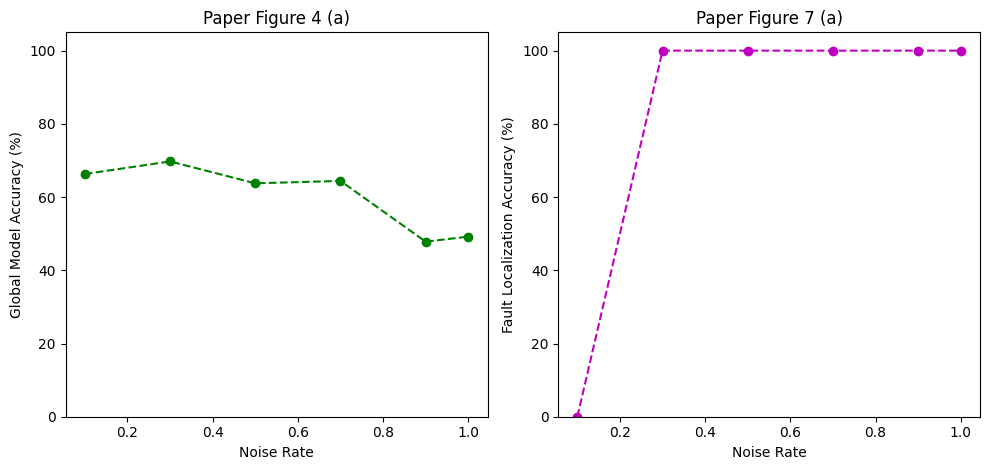

In [3]:
x =different_noise_levels 
y1_test_acc = [y[1] for y in nosie2results]
y2_fault_acc = [y[2] for y in nosie2results]
fig, axes = plt.subplots(1, 2) 
axes[0].plot(x, y1_test_acc, 'g--o') 
axes[1].plot(x, y2_fault_acc, 'm--o')

axes[0].set_xlabel('Noise Rate')
axes[1].set_xlabel('Noise Rate')
axes[0].set_ylabel('Global Model Accuracy (%)')
axes[1].set_ylabel('Fault Localization Accuracy (%)')
axes[0].set_title("Paper Figure 4 (a)")
axes[1].set_title("Paper Figure 7 (a)")

axes[0].set_ylim(0, 105)
axes[1].set_ylim(0, 105)

fig.set_figwidth(10)

plt.tight_layout()
